In [ ]:

from google.colab import drive
GOOGLE_COLAB= True

path = ""
if GOOGLE_COLAB:
    from google.colab import drive, files
    drive.mount('/content/gdrive/')
    path = "/content/drive/My Drive/Colab Notebooks/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200)
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train_tweets.csv')
test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/test_tweets.csv')

In [ ]:
train.shape, test.shape

((31962, 3), (17197, 2))

In [ ]:
train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [ ]:
train.tail(1000)

,id,label,tweet
30962,30963,0,@user @user -- christian senator prays for president's death and this is what frank tweets about.
30963,30964,0,#boom another #car #company going #electricvehicle on the world! #futureofwork #entrepreneur i'm
30964,30965,0,@user @user @user you best stick to selling younique. you're not a writer but you are a theif.
30965,30966,0,@user @user my best friend sunday
30966,30967,0,share #laughter with your #dad for the #happiest #fathersday ever!
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððððððâ¤ï¸
31958,31959,0,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher
31959,31960,0,listening to sad songs on a monday morning otw to work is sad
31960,31961,1,"@user #sikh #temple vandalised in in #calgary, #wso condemns act"


In [ ]:
train[train['label'] == 0].head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [ ]:
train[train['label'] == 1].head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


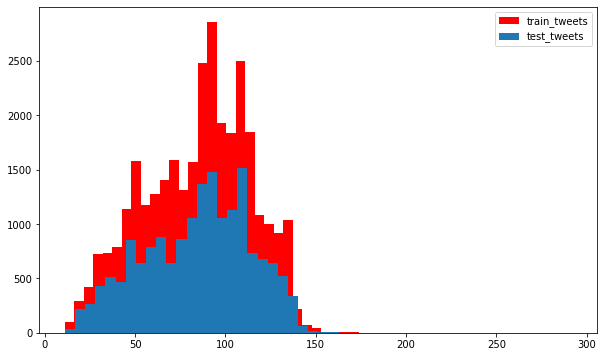

In [ ]:
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()
plt.figure(figsize=(10,6))
plt.hist(length_train, bins=50, label="train_tweets",color = 'red')
plt.hist(length_test, bins=50, label="test_tweets")
plt.legend()

In [ ]:
merge = train.append(test, ignore_index=True, sort=False)
merge.shape

(49159, 3)

In [ ]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [ ]:
merge['tidy_tweet'] = np.vectorize(remove_pattern)(merge['tweet'], "@[\w]*") 
merge.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [ ]:
merge['tidy_tweet'] = merge['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
merge.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


In [ ]:
merge['tidy_tweet'] = merge['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [ ]:
merge.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [ ]:
tokenized_tweet = merge['tidy_tweet'].apply(lambda x: x.split()) 
tokenized_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [ ]:
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0                   [when, father, dysfunct, selfish, drag, kid, into, dysfunct, #run]
1    [thank, #lyft, credit, caus, they, offer, wheelchair, van, #disapoint, #getthank]
2                                                              [bihday, your, majesti]
3                                                     [#model, love, take, with, time]
4                                                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [ ]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
merge['tidy_tweet'] = tokenized_tweet
merge.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunct selfish drag kid into dysfunct #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank #lyft credit caus they offer wheelchair van #disapoint #getthank
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


In [ ]:
from wordcloud import WordCloud
def plot_wordCloud(words):
    wordcloud = WordCloud(width=800, height=500, background_color='grey', random_state=21, max_font_size=110).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

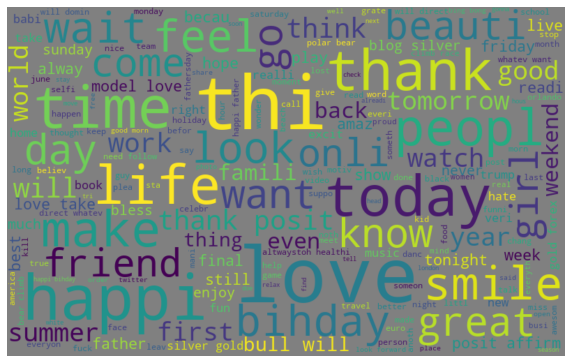

In [ ]:
all_words = ' '.join([text for text in merge['tidy_tweet']])
plot_wordCloud(all_words)

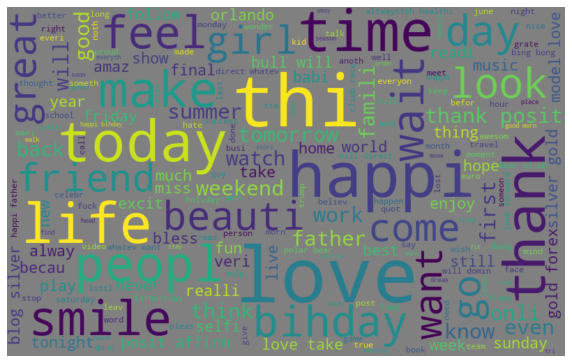

In [ ]:
normal_words =' '.join([text for text in merge['tidy_tweet'][merge['label'] == 0]])
plot_wordCloud(normal_words)

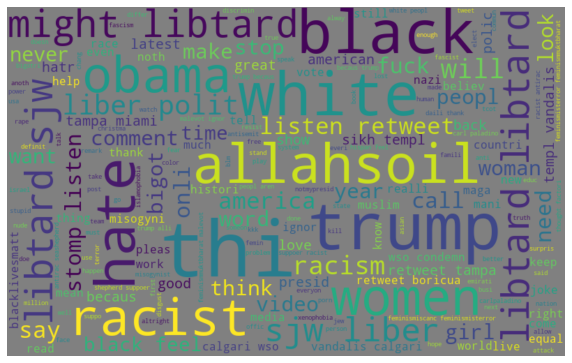

In [ ]:
negative_words = ' '.join([text for text in merge['tidy_tweet'][merge['label'] == 1]])
plot_wordCloud(negative_words)

In [ ]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [ ]:
# extracting hashtags from non racist tweets

HT_regular = hashtag_extract(merge['tidy_tweet'][merge['label'] == 0])

# extracting hashtags from racist tweets
HT_negative = hashtag_extract(merge['tidy_tweet'][merge['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

[Text(0, 0.5, 'Number of Tweets')]

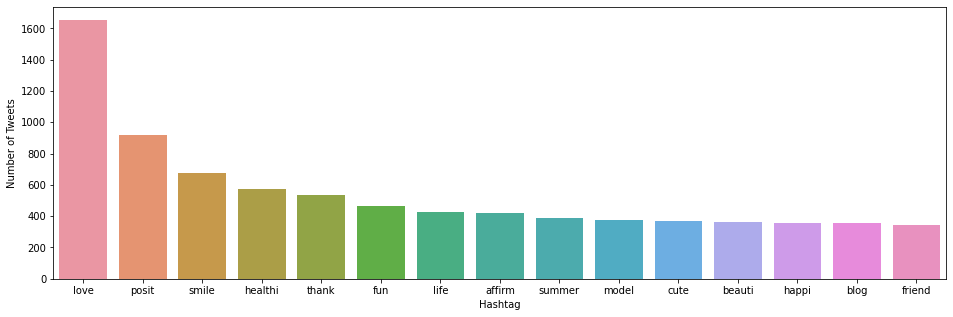

In [ ]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 15 most frequent hashtags     
d = d.nlargest(columns="Count", n = 15) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Number of Tweets')

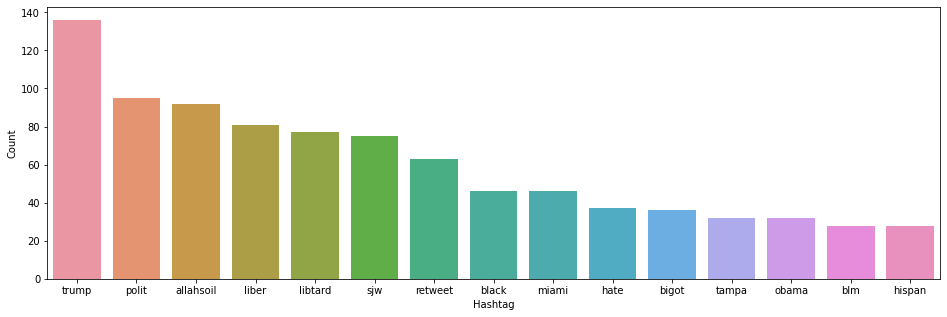

In [ ]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

# selecting top 15 most frequent hashtags
e = e.nlargest(columns="Count", n = 15)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")

In [ ]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(merge['tidy_tweet'])

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(merge['tidy_tweet'])

In [ ]:
tokenized_tweet = merge['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(merge['tidy_tweet']), epochs=20)

(6511528, 7536020)

In [ ]:
model_w2v.wv.most_similar(positive="thanku")

[('unborn', 0.8174856901168823),
 ('ant', 0.7954941987991333),
 ('sperm', 0.7861093282699585),
 ('minni', 0.785693883895874),
 ('#tvk', 0.7849346399307251),
 ('#aldubebfathersday', 0.7776422500610352),
 ('bane', 0.768250584602356),
 ('abba', 0.7640044689178467),
 ('#viamiano', 0.7622953653335571),
 ('#rogergoodel', 0.7594921588897705)]

In [ ]:
model_w2v.wv.most_similar(positive="hate")

[('muzzi', 0.5404025912284851),
 ('bigotri', 0.526186466217041),
 ('wat', 0.5136126279830933),
 ('baffl', 0.5019012093544006),
 ('conniv', 0.49921751022338867),
 ('heterosexu', 0.4988597333431244),
 ('#azealiabank', 0.4978216290473938),
 ('freed', 0.4964529573917389),
 ('sought', 0.49538689851760864),
 ('persecut', 0.4946410059928894)]

In [ ]:
len(model_w2v['donald'])

200

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(49159, 200)

In [ ]:
tqdm.pandas(desc="progress-bar")

In [ ]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

In [ ]:
labeled_tweets = add_label(tokenized_tweet) # label all the tweets


In [ ]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

100%|██████████| 49159/49159 [00:00<00:00, 2210181.05it/s]


In [ ]:
model_d2v.train(labeled_tweets, total_examples= len(merge['tidy_tweet']), epochs=15)

In [ ]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(merge)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))
    
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

(49159, 200)

In [ ]:
MODEL_ID = []
Accuracy = []
LOG_CV_ERR = []
F1Score = []
def calculate_log_cv_error(logmodel,X_train,y_train):
    ms_errors= cross_val_score(logmodel, X_train, y_train, cv=5, scoring = make_scorer(mean_squared_error))
    rms_errors = np.sqrt(ms_errors)
    mean_rms_error = rms_errors.mean()
    return mean_rms_error

In [ ]:
def evaluate_model(logmodel,X_train,X_test,y_train,y_test,predictions):
    log_cv_error = calculate_log_cv_error(logmodel,X_train,y_train)
    print(f'\nClassification Report:\n{classification_report(y_test,predictions)}')
    print('')
    print(f'\nConfusion Matrix:\n{confusion_matrix(y_test,predictions)}')
    print('')
    print (f'\nAccuracy Score:  {accuracy_score(y_test,predictions)}')
    print("Cross Validation Error: ",log_cv_error)
    logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
    LOG_CV_ERR.append(log_cv_error)
    plt.figure()
    plt.plot(fpr, tpr, label='Naive Bayes (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    

In [ ]:
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [ ]:
model = BernoulliNB()

model.fit(xtrain_bow, ytrain) # training the model

prediction = model.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5078534031413612


In [ ]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

In [ ]:
model.fit(xtrain_tfidf, ytrain)

prediction = model.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5078534031413612


In [ ]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

In [ ]:
model.fit(xtrain_w2v, ytrain)

prediction = model.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.4428389290267743



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      8905
           1       0.31      0.76      0.44       684

    accuracy                           0.86      9589
   macro avg       0.65      0.82      0.68      9589
weighted avg       0.93      0.86      0.89      9589



Confusion Matrix:
[[7757 1148]
 [ 163  521]]


Accuracy Score:  0.8632808426321827
Cross Validation Error:  0.34904587483017824


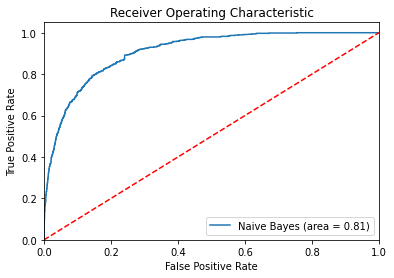

In [ ]:
evaluate_model(model,xtrain_w2v,xvalid_w2v,ytrain,yvalid,prediction_int)
MODEL_ID.append('Naive Bayes')
Accuracy.append(accuracy_score(yvalid, prediction_int))
F1Score.append(f1_score(yvalid, prediction_int))